### Standardized Mooring Supply Chain Analysis


In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ORBIT import ProjectManager, load_config

from ORBIT.phases.design import CustomMooringSystemDesign
from ORBIT.phases.install import MooringSystemSupplyChain

In [2]:
INPUTS = os.path.join(os.getcwd(), "inputs")
RESULTS = os.path.join(os.getcwd(), "results")
if not os.path.exists(RESULTS):
    os.mkdir(RESULTS)

#### Morro Bay config

In [3]:
config_MB = load_config(os.path.join(INPUTS, "custom_MorroBay.yaml"))

weather_MB = None

num_turbines = config_MB["plant"]["num_turbines"]
print("Distance: ", config_MB["site"]["distance"])
print("Number of Turbines: ", num_turbines)
print("Turbine: ", config_MB["turbine"])

config_MB["custom_filename"] = "custom_mooring_MorroBay_full.csv"


Distance:  100
Number of Turbines:  40
Turbine:  15MW_generic


In [4]:
try:
  ProjectManager.register_design_phase(CustomMooringSystemDesign)
  ProjectManager.register_install_phase(MooringSystemSupplyChain)

except ValueError:
  pass

baseline_MB = ProjectManager(config_MB, weather=weather_MB)
baseline_MB.run()

print(f"\nPhases: {list(baseline_MB._phases)}")
print(f"\n : {baseline_MB.design_results}")
print(
      f"\nLead Time: {baseline_MB.installation_time:.0f} h ({baseline_MB.installation_time/8760:.2f} years)"
    )

ORBIT library intialized at '/Users/nriccobo/GitHub/ORBIT/library'
     turbine_id line_id      section_id  diameter  length  thickness   mass  \
0             1       A  suction_anchor      2.34   14.04         53  54.23   
1             1       B  suction_anchor      2.59   12.95         58  62.35   
2             1       C  suction_anchor      2.59   12.94         58  62.21   
3             1       D  suction_anchor      2.34   14.03         53  54.06   
4             1       E  suction_anchor      2.60   12.98         58  62.69   
..          ...     ...             ...       ...     ...        ...    ...   
235          40       B  suction_anchor      2.36   14.17         54  55.61   
236          40       C  suction_anchor      2.17   15.20         50  49.92   
237          40       D  suction_anchor      2.59   12.95         60  62.34   
238          40       E  suction_anchor      2.37   14.21         50  56.14   
239          40       F  suction_anchor      2.20   15.39       

In [5]:
df_actions_MB = pd.DataFrame(baseline_MB.actions)

pd.DataFrame(df_actions_MB).to_csv(
        os.path.join(RESULTS, "MorroBay_full_project.csv")
)
df_actions_MB

,cost,supply_storage,agent,action,duration,level,time,phase,transport_storage,delivered,port_storage,port_area
0,0.0,1.0,Chain Production 1,"1, Manufacture: chain_bottom_d0.083",7.0000,ACTION,7.0000,MooringSystemSupplyChain,NaN,NaN,NaN,NaN
1,0.0,NaN,Chain Transport Railcar,Waiting for Chain to load.,7.0000,ACTION,7.0000,MooringSystemSupplyChain,NaN,NaN,NaN,NaN
2,0.0,NaN,Chain Transport Railcar,"Loading Chain, 1",0.0000,ACTION,7.0000,MooringSystemSupplyChain,1.0,NaN,NaN,NaN
3,0.0,1.0,Chain Production 1,"2, Manufacture: chain_bottom_d0.084",6.9825,ACTION,13.9825,MooringSystemSupplyChain,NaN,NaN,NaN,NaN
4,0.0,NaN,Chain Transport Railcar,Waiting for Chain to load.,6.9825,ACTION,13.9825,MooringSystemSupplyChain,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
4063,0.0,NaN,Rope Transport Railcar,Unload Rope at Port Laydown.,0.0000,ACTION,53704.1731,MooringSystemSupplyChain,3.0,NaN,665.0,548.921661
4064,0.0,NaN,Rope Transport Railcar,Unload Rope at Port Laydown.,0.0000,ACTION,53704.1731,MooringSystemSupplyChain,2.0,NaN,665.0,548.921661
4065,0.0,NaN,Rope Transport Railcar,Unload Rope at Port Laydown.,0.0000,ACTION,53704.1731,MooringSystemSupplyChain,1.0,NaN,665.0,548.921661
4066,0.0,NaN,Rope Transport Railcar,Unload Rope at Port Laydown.,0.0000,ACTION,53704.1731,MooringSystemSupplyChain,0.0,NaN,665.0,548.921661


['Chain Production 1' 'Chain Transport Railcar' 'Anchors Production 1'
 'Anchor Transport Vessel' 'Ropes Production 1' 'Rope Transport Railcar']


set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

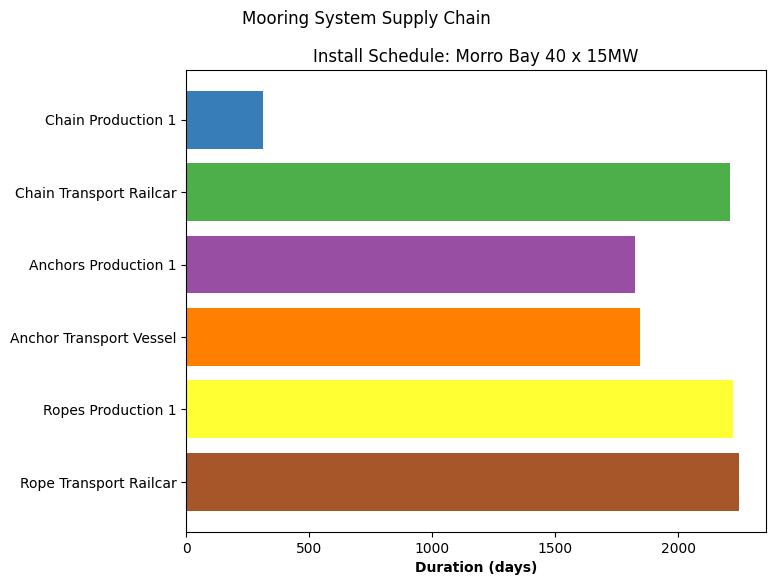

In [6]:
# Plot logic
import numpy as np
plot_based_on = 'agent'

agents = df_actions_MB['agent'].unique()
#agents = ['Substructure Assembly Line 1', '3 Tugs (Group 1)', 'AHTS + 2 Tugs']
print(agents)

#wrapped_agents_dic = [textwrap.fill(a, width=16) for a in agents]

color_sns_hex= (sns.color_palette("Set1").as_hex() +
                sns.color_palette("Set2").as_hex() +
                sns.color_palette("Set3").as_hex()
)

def color(row):

    c_dict = {agents[i]: color_sns_hex[i+1] for i in range(len(agents))}
    #print(c_dict)
    return c_dict[row['agent']]

df_plot = df_actions_MB
df_plot['color'] = df_plot.apply(color, axis=1)

# make delays red
df_plot.loc[df_plot["action"].str.contains('Delay'), "color"] = '#FF0000'

fig, ax = plt.subplots(1, figsize=(10,6))
fig.suptitle("Mooring System Supply Chain")

ax.barh(y=df_plot[plot_based_on],
           width=(df_plot['duration'])/24,
           left=(df_plot['time']-df_plot['duration'])/24,
           color=df_plot.color)

ax.set_title(f"Install Schedule: Morro Bay {num_turbines} x 15MW")

num_x_labels = 5
#day_spacing = int(((df_plot['end_date'].max() - df_plot['start_date'].min()).days)/num_x_labels)
#xticks = np.arange(0, df_plot['days_to_end'].max()+1, day_spacing)
#ax.set_xticks(xticks)
ax.set_xlabel("Duration (days)", fontdict=dict(weight='bold'))

ax.set_yticklabels(agents)
plt.gca().invert_yaxis()
fig.subplots_adjust(left=0.32)

plt.show()

